# Test of combining TL Diffuser and SPACE on a tiny grid

*(GT July 2022)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, Component, create_grid
from landlab.components import FlowAccumulator, SpaceLargeScaleEroder

In [2]:
class Tr_L_diff(Component):

    r"""Transport length hillslope diffusion.
    #TODO
    Correct for rho soil vs bedrock
    Component written by Benjamin Campforts, 2022
    Parameters
    ----------
    grid : ModelGrid
        Landlab ModelGrid object
    erodibility: float
        Erodibility coefficient [L/T]
    slope_crit: float (default=1.)
        Critical slope [L/L]
    depositOnBoundaries: boolean (default=False)
    depthDependent: boolean (default=False)
    H_star=1.0 : float (default=1.)
    Examples
    --------
    References
    ----------
    **Required Software Citation(s) Specific to this Component**
    None Listed
    **Additional References**
    Carretier, S., Martinod, P., Reich, M., Godderis, Y. (2016). Modelling
    sediment clasts transport during landscape evolution. Earth Surface Dynamics
    4(1), 237-251. https://dx.doi.org/10.5194/esurf-4-237-2016
    Davy, P., Lague, D. (2009). Fluvial erosion/transport equation of landscape
    evolution models revisited. Journal of Geophysical Research  114(F3),
    F03007. https://dx.doi.org/10.1029/2008jf001146
    """

    _name = "TransportLengthHillslopeDiffuser"

    _unit_agnostic = True

    _info = {
        "flow__receiver_node": {
            "dtype": int,
            "intent": "in",
            "optional": False,
            "units": "-",
            "mapping": "node",
            "doc": "Node array of receivers (node that receives flow from current node)",
        },
        "topographic__steepest_slope": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m/m",
            "mapping": "node",
            "doc": "The steepest *downhill* slope",
        },
        "topographic__elevation": {
            "dtype": float,
            "intent": "inout",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Land surface topographic elevation",
        },
        "bedrock__elevation": {
            "dtype": float,
            "intent": "inout",
            "optional": True,
            "units": "m",
            "mapping": "node",
            "doc": "Bedrock elevation",
        },
        "soil__depth": {
            "dtype": float,
            "intent": "inout",
            "optional": True,
            "units": "m",
            "mapping": "node",
            "doc": "Sediment thickness",
        },

        "sediment_flux_out": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Sediment flux at boundary nodes in m3",
        },
    }

    def __init__(
        self,
        grid,
        erodibility=0.001,
        slope_crit=1.0,
        depositOnBoundaries=False,
        depthDependent=False,
        H_star=1.0,
        transportLengthCoefficient=None
    ):

        """Initialize Diffuser.
        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        erodibility: float
            Erodibility coefficient [L/T]
        slope_crit: float (default=1.)
            Critical slope [L/L]
        depositOnBoundaries: boolean (default=False)
        depthDependent: boolean (default=False)
        H_star=1.0 : float (default=1.)

        transportLengthCoefficient [default = dx]
        """
        self._depthDependent = depthDependent
        if self._depthDependent:
            self._info["soil__depth"]["optional"] = False
            self._info["bedrock__elevation"]["optional"] = False
            # Depth scale
            self._H_star = H_star

        super().__init__(grid)

        if grid.at_node["flow__receiver_node"].size != grid.size("node"):
            msg = (
                "A route-to-multiple flow director has been "
                "run on this grid. The landlab development team has not "
                "verified that TransportLengthHillslopeDiffuser is compatible "
                "with route-to-multiple methods. Please open a GitHub Issue "
                "to start this process."
            )
            raise NotImplementedError(msg)

        # Store grid and parameters

        self._k = erodibility
        self._slope_crit = slope_crit
        if transportLengthCoefficient is None:
            self._transportLengthCoefficient = grid.dx
        else:
            if transportLengthCoefficient < grid.dx:
                raise ValueError("The value for transportLengthCoefficient must be larger than the grid resolution")
            else:
                self._transportLengthCoefficient = transportLengthCoefficient
        # Create fields:
        # Elevation
        self._el = self._grid.at_node["topographic__elevation"]
        # Soil
        if self._depthDependent:
            self._soil = self._grid.at_node["soil__depth"]
            self._bed = self._grid.at_node["bedrock__elevation"]

        self._steepest = self._grid.at_node["topographic__steepest_slope"]
        self._r = self._grid.at_node["flow__receiver_node"]
        self._lk_rcvr = self.grid.at_node["flow__link_to_receiver_node"]
        self._stack = self.grid.at_node["flow__upstream_node_order"]
        self._link_lengths = self.grid.length_of_d8

        self.initialize_output_fields()
        self._depositOnBoundaries = depositOnBoundaries

        self._flux  = self._grid.at_node["sediment_flux_out"]

    def tldiffusion(self, dt):
        """Calculate hillslope diffusion for a time period 'dt'.
        Parameters
        ----------
        grid : ModelGrid
            Landlab ModelGrid object
        dt: float (time)
            The imposed timestep.
        """
        print(' TrLdiff tldiffusion here')

        dx = self._grid.dx
        lakes = self._steepest < 0

        if self._depthDependent:
            ero = self._k * self._steepest * (1 - np.exp(-self._soil / self._H_star))
            ero = np.minimum(ero * dt, self._soil) / dt
            print('Ddep, ero =', ero[self.grid.core_nodes],
                  'soil =', self._soil[self.grid.core_nodes])
        else:
            # Calcualte erosion -- in comparison to v1, not curring off at Sc
            ero = self._k * self._steepest

        ero[lakes] = 0

        L = np.where(
            self._steepest < self._slope_crit,
            self._transportLengthCoefficient / (1 - (self._steepest / self._slope_crit) ** 2),
            1e9,
        )


        qs_out = np.zeros_like(self._el)
        depo = np.zeros_like(self._el)



        stack_flip_ud = np.flipud(self._stack)
        if self._depositOnBoundaries:
            stack_flip_ud_sel = stack_flip_ud
        else:
            node_status = self.grid.status_at_node
            stack_flip_ud_sel = stack_flip_ud[
                (node_status[stack_flip_ud] == self.grid.BC_NODE_IS_CORE)]

        # C-code
        #non_local_Depo(dx, stack_flip_ud_sel , self._r, qs_out, L, ero, depo)
        # Non C-Code
        for node in stack_flip_ud_sel:
            # L has to be larger than dx
            depo[node] = qs_out[node]/L[node]
            qs_out[self._r[node]] += qs_out[node]+ (ero[node]- depo[node])*dx

        # Update flux
        self._flux[:] = qs_out*dx # in m3
        # Update elevation
        if self._depthDependent:
            self._soil += (-ero + depo) * dt
            self._el = self._soil + self._bed
        else:
            self._el += (-ero + depo) * dt

    def run_one_step(self, dt):
        """Advance one timestep.
        Advance transport length-model hillslope diffusion component
        by one time step of size dt and tests for timestep stability.
        Parameters
        ----------
        dt: float (time)
            The imposed timestep.
        """
        print('TrLdiff ROS here')
        elev_dif_before = self._el - self._el[self._r]
        flow__sink_flag = elev_dif_before < 0
        self.tldiffusion(dt)

        # Test code stability for timestep dt
        # Raise unstability error if local slope is reversed by erosion
        # and deposition during a timestep dt
        elev_dif = self._el - self._el[self._r]
        s = elev_dif[np.where(flow__sink_flag == 0)]
        if np.any(s < -1) is True:
            raise ValueError(
                "The component is unstable" " for such a large timestep " "on this grid"
            )
        else:
            pass


In [3]:
class MiniModelTester:
    """Model that tests combinations of transport-length diffusion
    and SPACE on a tiny grid.

    Parameters
    ----------
    grid_params : dict
        Dictionary of grid parameters (for format see create_grid)
    flow_params : dict
        Dictionary with FlowAccumulator parameters
    fluvial_params : dict, default empty
        Dictionary with SPACE parameters
    hillslope_params : dict, default empty
        Dictionary with TLDiff parameters
    initial_noise_amplitude : float, default 0
        Amplitude of random noise on initial topography
    uplift_rate : float, default 0.0001
        Applied uplift (baselevel) rate in m/y
    run_duration : float, default 1.0e4
        Duration of run in years
    dt : float, default 100
        Time-step duration, years
    grid_setup_fn : function, default None
        Handle to user-defined function to set up the grid
    grid_setup_params : dict, default empty
        Dict with any parameters to be passed to the above function
    """

    _DEFAULT_GRID_PARAMS = {
        "RasterModelGrid": {
            "shape": (4, 5),
            "xy_spacing": 2.0,
            "fields": {
                "node": {
                    "topographic__elevation": {
                        "constant": [{"value": 0.0}]},
                    "bedrock__elevation": {
                        "constant": [{"value": -1.0}]},
                    "soil__depth": {
                        "constant": [{"value": 1.0}]}},
            },
        }
    }

    _DEFAULT_FLOW_PARAMS = {"flow_director": "FlowDirectorD8"}

    _DEFAULT_FLUVIAL_PARAMS = {}

    _DEFAULT_HILLSLOPE_PARAMS = {
        "depthDependent": True,
    }

    def __init__(
        self,
        grid_params=_DEFAULT_GRID_PARAMS,
        flow_params=_DEFAULT_FLOW_PARAMS,
        fluvial_params=_DEFAULT_FLUVIAL_PARAMS,
        hillslope_params=_DEFAULT_HILLSLOPE_PARAMS,
        initial_noise_amplitude=0.0,
        uplift_rate=0.0,
        run_duration=1.0,
        dt=1.0,
        grid_setup_fn=None,
        grid_setup_params={},
    ):
        """Initialize GravelRiverNetworkModel."""

        self.grid = create_grid({**self._DEFAULT_GRID_PARAMS, **grid_params})
        self.elev = self.grid.at_node["topographic__elevation"]
        self.br = self.grid.at_node["bedrock__elevation"]
        self.soil = self.grid.at_node["soil__depth"]
        if grid_setup_fn is not None:
            grid_setup_fn(self.grid, **grid_setup_params)
        if initial_noise_amplitude > 0.0:
            self.elev[self.grid.core_nodes] += initial_noise_amplitude * np.random.rand(
                self.grid.number_of_core_nodes
            )
        self.flow_handler = FlowAccumulator(
            self.grid, **{**self._DEFAULT_FLOW_PARAMS, **flow_params}
        )
        self.eroder = SpaceLargeScaleEroder(
            self.grid, **{**self._DEFAULT_FLUVIAL_PARAMS, **fluvial_params}
        )
        self.diffuser = Tr_L_diff(
            self.grid, **{**self._DEFAULT_HILLSLOPE_PARAMS, **hillslope_params}
        )
        self.uplift_rate = uplift_rate
        self.time_remaining = run_duration
        self.dt = dt

    def run(self):
        """Run model from start to finish."""
        while self.time_remaining > 0.0:
            dt = min(self.dt, self.time_remaining)
            self.update(dt)
            self.time_remaining -= dt

    def update(self, dt):
        """Update for one time step of duration dt."""
        self.elev[self.grid.core_nodes] += self.uplift_rate * dt
        self.flow_handler.run_one_step()
        self.diffuser.run_one_step(dt)
        self.eroder.run_one_step(dt)

In [4]:
def tiny_setup(grid):
    """Set boundary nodes to CLOSED except the right side"""
    grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
    grid.status_at_node[1] = grid.BC_NODE_IS_FIXED_VALUE
    elev = grid.at_node["topographic__elevation"]
    br = grid.at_node["bedrock__elevation"]
    soil = grid.at_node["soil__depth"]
    elev[5] = 1.1
    elev[6] = 0.1
    br[5] = 0.1
    br[6] = -0.9
    soil[5] = 1.0
    soil[6] = 1.0

In [5]:
# Parameters
nrows = 3
ncols = 4
dx = 2.0
run_duration = 2.0  # duration of run, years
dt = 1.0  # time-step duration, years


In [6]:
def set_params():
    grid_params = {
        "RasterModelGrid": {
            "shape": (nrows, ncols),
            "xy_spacing": dx,
                "fields": {
                    "node": {
                        "topographic__elevation": {
                            "constant": [{"value": 0.0}]},
                        "bedrock__elevation": {
                            "constant": [{"value": -1.0}]},
                        "soil__depth": {
                            "constant": [{"value": 1.0}]}},
                },
        }
    }

    flow_params = {
        "flow_director": "FlowDirectorD8",
    }

    fluvial_params = {

    }

    hillslope_params = {

    }
    return grid_params, flow_params, fluvial_params, hillslope_params

In [7]:
grid_params, flow_params, fluvial_params, hillslope_params = set_params()
model = MiniModelTester(
    grid_params,
    flow_params,
    fluvial_params,
    hillslope_params=hillslope_params,
    uplift_rate=0.0,
    run_duration=run_duration,
    dt=dt,
    grid_setup_fn=tiny_setup,
)

In [8]:
model.run()

TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.39361918e-04   2.21047945e-05] soil = [ 0.9839396   0.99896759]


In [9]:
print(model.elev[5:7])
print(model.br[5:7])
print(model.soil[5:7])

[ 1.06811467  0.09794573]
[ 0.09999747 -0.90000013]
[ 0.96811719  0.99794586]


In [10]:
# Experiment with K_sed
Ksed_vals = np.arange(0.0025, 0.0225, 0.0025)
elev_loss_var_Ksed = np.zeros(len(Ksed_vals))
i = 0
for Ksed in Ksed_vals:
    grid_params, flow_params, fluvial_params, hillslope_params = set_params()
    fluvial_params["K_sed"] = Ksed
    model = MiniModelTester(
        grid_params.copy(),
        flow_params,
        fluvial_params,
        hillslope_params=hillslope_params,
        uplift_rate=0.0,
        run_duration=run_duration,
        dt=dt,
        grid_setup_fn=tiny_setup,
    )
    model.run()
    elev_loss_var_Ksed[i] = 1.2 - np.sum(model.elev[5:7])
    i += 1

TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.46468344e-04   2.23136899e-05] soil = [ 0.99768886  0.99985143]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.45451188e-04   2.22838358e-05] soil = [ 0.99572466  0.99972517]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.44434678e-04   2.22539857e-05] soil = [ 0.99376048  0.99959891]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.43418817e-04   2.22241396e-05] soil = [ 0.99179629  0.99947264]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04

[ 0.00491605  0.0090843   0.01324521  0.01739878  0.021545    0.02568388
  0.02981542  0.03393961]


Text(0, 0.5, 'Elev loss')

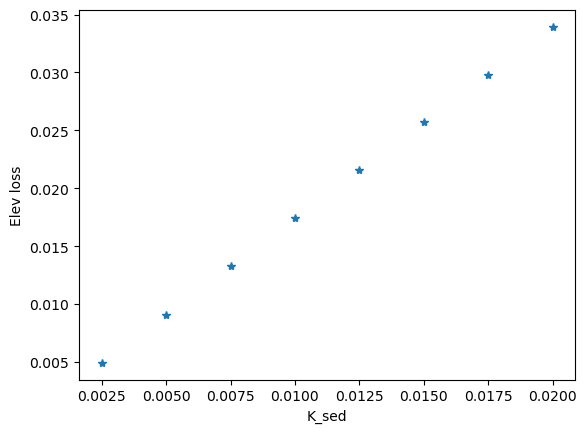

In [11]:
print(elev_loss_var_Ksed)
plt.plot(Ksed_vals, elev_loss_var_Ksed, '*')
plt.xlabel('K_sed')
plt.ylabel("Elev loss")

In [12]:
# Experiment with Tr L diff erodibility
erody_vals = np.arange(0.00025, 0.00225, 0.00025)
elev_loss_var_erody = np.zeros(len(erody_vals))
i = 0
for erody in erody_vals:
    grid_params, flow_params, fluvial_params, hillslope_params = set_params()
    hillslope_params["erodibility"] = erody
    model = MiniModelTester(
        grid_params.copy(),
        flow_params,
        fluvial_params,
        hillslope_params=hillslope_params,
        uplift_rate=0.0,
        run_duration=run_duration,
        dt=dt,
        grid_setup_fn=tiny_setup,
    )
    model.run()
    elev_loss_var_erody[i] = 1.2 - np.sum(model.elev[5:7])
    i += 1

TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  8.69165768e-05   5.58720917e-06] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  8.48740971e-05   5.52718857e-06] soil = [ 0.98420034  0.99898435]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  1.73833154e-04   1.11744183e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  1.69725782e-04   1.10537172e-05] soil = [ 0.98411343  0.99897877]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  2.60749731e-04   1.67616275e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  2.54555055e-04   1.65795858e-05] soil = [ 0.98402651  0.99897318]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.47666307e-04   2.23488367e-05] soil = [ 1.  1.]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  3.39361918e-04   2.21047945e-05] soil = [ 0.9839396   0.99896759]
TrLdiff ROS here
 TrLdiff tldiffusion here
Ddep, ero = [  4.34582884e-04

[ 0.03339493  0.03357651  0.03375807  0.03393961  0.03412112  0.03430261
  0.03448408  0.03466552]


Text(0, 0.5, 'Elev loss')

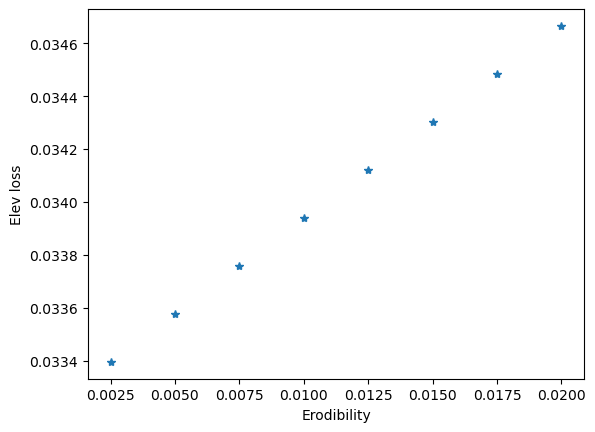

In [13]:
print(elev_loss_var_erody)
plt.plot(Ksed_vals, elev_loss_var_erody, '*')
plt.xlabel('Erodibility')
plt.ylabel("Elev loss")